### Enable autoreload

In [1]:
# Sørger for at alle importerede python filer geninlæses ved import statements
# Nødvedigt, hvis ændinger skal tage effekt uden at genstarte Python Kernel
%load_ext autoreload
%autoreload 2

#  Simuleringer 

### Econometrics A (ØkA)

Bertel Schjerning

Department of Economics, University of Copenhagen


# Part 1: Introduktion til Monte Carlo Simulation

### Hvorfor bruge Monte Carlo simulationer?

- **Monte Carlo simulationer** genererer data gentagne gange fra en specifik model, for herefter at estimere modellen mhp at studere estimatorers egenskaber.

- Monte Carlo simulationer giver os f.eks. mulighed for at:
    - Undersøge OLS-estimatorernes egenskaber i **små** og **store** stikprøver.
    - Evaluere konsekvenserne af overtrædelser af OLS-antagelser (f.eks. multikollinearitet, korrelerede fejlled, heteroskedasticitet).
    - Analysere teststørrelser og fejltyper (Type 1 og Type 2 fejl) under forskellige forhold.
    
For at kunne simulere, skal vi først specificere den data genererende process (DGP)

### Monte Carlo Simulation
**Formuler model**
$$
\begin{align}
y_i &= \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + u_i 
\quad u_i \sim \mathcal{N}(0, \sigma_u^2) \\
x_{1i} &\sim \mathcal{N}(\mu_{x_1}, \sigma_{x_1}^2) \\
x_{2i} &= \rho_x x_{1i} + \rho_{xu} u_i + \eta_i, \quad \eta_i \sim \mathcal{N}(\mu_\eta, \sigma_\eta^2)
\end{align}
$$

**Procedure:**
1. **Simulér data for** $u_i$, $\eta_i$, $x_{1i}$, $x_{2i}$ og $y_i$
2. Estimér $\mathbf{\hat{\beta}} = (\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2)'$ og beregn standardfejl i hver simulation $s$
3. Gentag trin 1-2 mange gange og gem estimater og standardfejl for hver $s = 1, \dots, S$
4. Analyser fordelingerne af de $S$ estimater, deres standardfejl, teststatistikker osv.

**Eksempel på analyse:**
- Histogrammer af $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, deres standardfejl, teststatistikker osv.
- Sammenligningstabel, der viser gennemsnitlige estimater, standardafvigelser og sande værdier.

# Part 2: Simulation fra en lineær model

### Indlæs nødvendige libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import mymlr as mlr
np.set_printoptions(precision=4, suppress=False, floatmode='maxprec_equal', formatter={'float_kind': '{:g}'.format})

### Simuler data fra modellen
\begin{align}
y_i &= \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + u_i 
\quad u_i \sim \mathcal{N}(0, \sigma_u^2)
\\ x_{1i} &\sim \mathcal{N}(\mu_{x_1}, \sigma_{x_1}^2)
\\ x_{2i} &= \rho_x x_{1i} + \rho_{xu} u_i + \eta_{i}, \quad \eta_{i} \sim \mathcal{N}(\mu_{\eta},\sigma_{\eta}^2)
\end{align}


In [3]:
def simulate(n=100, beta=[0, 1, 2], sigma_u=1,
             mu_x1=0, sigma_x1=1, mu_eta=1, sigma_eta=1,
             rho_x=0, rho_xu=0, dist='normal'):
    
    if dist == 'normal':
        gen = np.random.normal
    if dist == 'uniform':
        gen = np.random.uniform(-np.sqrt(3), np.sqrt(3), size)*sigma + mu
    elif dist == 't':
        gen = lambda mu, sigma, size: np.random.standard_t(3, size)*sigma + mu

    const = np.ones(n)
    u = gen(0, sigma_u, size=n)
    x1 = gen(mu_x1, sigma_x1, size=n)
    eta = gen(mu_eta, sigma_eta, size=n)
    x2 = rho_x * x1 + rho_xu * u + eta
    y = beta[0] + beta[1] * x1 + beta[2] * x2 + u
    
    return pd.DataFrame({'y': y,'const': const,'x1': x1,'x2': x2, 'u': u, 'eta': eta})

### Simuler data og lav beskrivende statistik

In [4]:
# Kør koden flere gange: Hvorfor ændrer data sig? Hvad sker der når n er stor?
# Prøv at ændre n, beta, sigma_u, mu_x1, sigma_x1, mu_eta, sigma_eta, rho_x, rho_xu, dist ('normal' eller 't')
df = simulate(n=10000, beta=[0, 1, 2], sigma_u=1, mu_x1=0, sigma_x1=1, mu_eta=1, sigma_eta=0.00001,rho_x=1, rho_xu=0, dist='normal')
print(f'Beskrivende statistik:'); display(df.describe().round(3))
print(f'Correlations matrix:'); display(df.corr().round(3))

Beskrivende statistik:


,y,const,x1,x2,u,eta
count,10000.000,10000.0,10000.000,10000.000,10000.000,10000.0
mean,2.008,1.0,0.002,1.002,0.001,1.0
std,3.197,0.0,1.011,1.011,1.007,0.0
min,-10.457,1.0,-4.123,-3.123,-3.854,1.0
25%,-0.118,1.0,-0.676,0.324,-0.678,1.0
50%,1.985,1.0,0.021,1.021,0.001,1.0
75%,4.190,1.0,0.684,1.684,0.674,1.0
max,15.103,1.0,3.931,4.931,4.478,1.0


Correlations matrix:


,y,const,x1,x2,u,eta
y,1.000,NaN,0.949,0.949,0.317,-0.012
const,NaN,NaN,NaN,NaN,NaN,NaN
x1,0.949,NaN,1.000,1.000,0.003,-0.015
x2,0.949,NaN,1.000,1.000,0.003,-0.015
u,0.317,NaN,0.003,0.003,1.000,0.006
eta,-0.012,NaN,-0.015,-0.015,0.006,1.000


### Histogram til at visualisere fordelinger

In [5]:
def histogram(stat, truestat=None, title='Histogram', xlim=None, bins=50, normdensity=True):
    plt.rcParams.update({'font.size': 16})
    if truestat is None:
        truestat = stat.mean().to_numpy()
    else: 
        truestat = np.asarray(truestat)
    fig, ax = plt.subplots(1, len(stat.columns), figsize=(15, 4))
    for i, lbl in enumerate(stat.columns):
        mcsd = stat[lbl].std();
        ax[i].hist(stat[lbl], bins=bins, density=True, alpha=0.7)
        ax[i].axvline(x=truestat[i], color='red', linestyle='--')
        if normdensity:
            x = np.linspace(truestat[i]-4*mcsd, truestat[i]+4*mcsd, 100)
            y = norm.pdf(x, loc=truestat[i], scale=mcsd)
            ax[i].plot(x, y, color='black')
        ax[i].set_title(lbl)
        if xlim is not None:
            ax[i].set_xlim(xlim)
        else:
            ax[i].set_xlim(truestat[i]-4*mcsd, truestat[i]+4*mcsd)

    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

### Visualiser fordeling af data

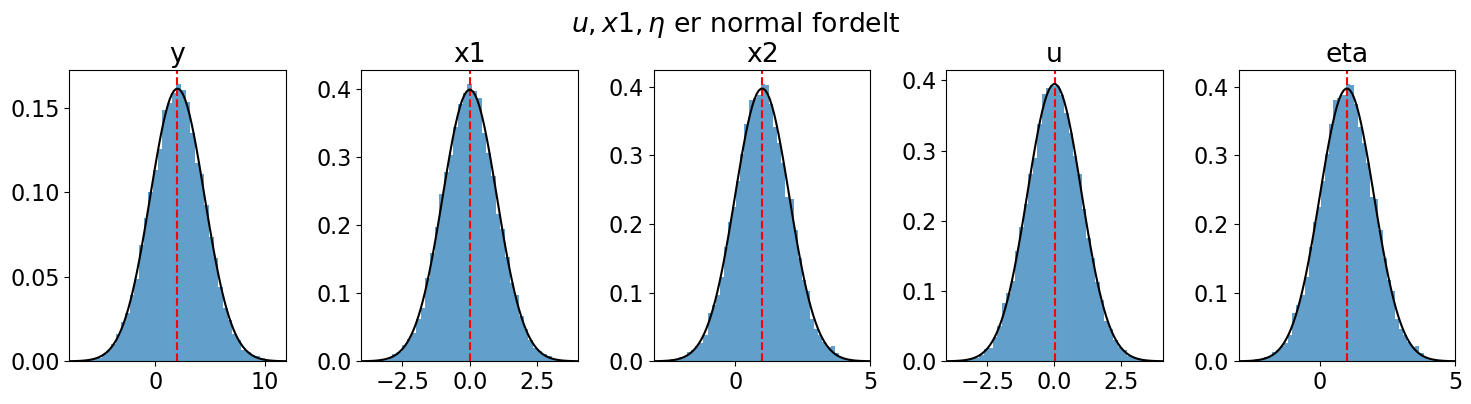

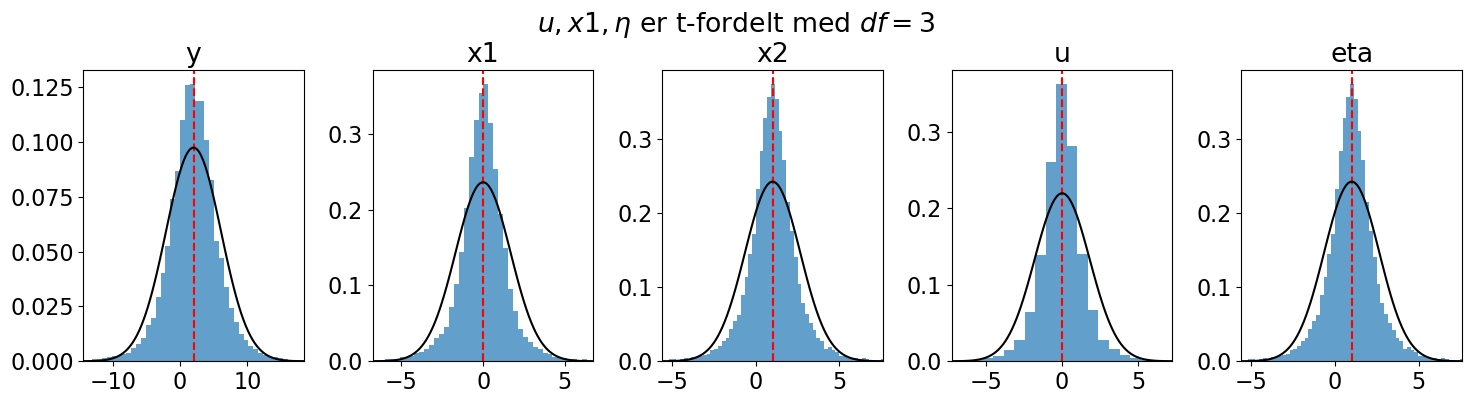

In [6]:
df1 = simulate(n=20000, dist='normal') # u, x1, og η er normal fordelt
histogram(df1[['y','x1','x2', 'u', 'eta']], title=f'$u, x1, \\eta$ er normal fordelt ')
df2 = simulate(n=20000, dist='t') # u, x1, og η er - fordelt med 3 frihedsgrader - samme middelværdi og varians
histogram(df2[['y','x1','x2', 'u', 'eta']], title=f'$u, x1, \\eta$ er t-fordelt med $df=3$', bins=200);

## Plan for Monte Carlo
1. Simulér data for $u_i$, $\eta_i$, $x_{1i}$, $x_{2i}$ og $y_i$
2. **Estimér $\mathbf{\hat{\beta}} = (\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2)'$ og beregn standardfejl i hver simulation $s$**
3. Gentag trin 1-2 mange gange og gem estimater og standardfejl for hver $s = 1, \dots, S$
4. Analyser fordelingerne af de $S$ estimater, deres standardfejl, teststatistikker osv.


### Simuler data og estimer model med OLS
- Er MLR.1-MLR.4' opfyldt? Er $\mathbf{\hat{\beta}}$ konsistent for $\beta$
- Hvad sker der når n er stor? Er $p\lim \mathbf{\hat{\beta}}=\mathbf{\beta}$ 
- Hvad sker der når $\sigma_{\eta}=0$ (eller meget lille)
- Hvad sker der når $\rho_{xu} \ne 0$?
- Kan vi sige noget om middelret hed ud fra et Monte Carlo sample?

In [7]:
# Kør koden flere gange: Hvorfor ændrer beta sig? 
df = simulate(n=10000, beta=[0,1,2], sigma_u=1, mu_eta=1, sigma_eta=.1, rho_x=1, rho_xu=0) 
res=mlr.ols(df[['const', 'x1', 'x2']],df['y'])
mlr.output(res)
df = simulate(n=10000, beta=[0,1,2], sigma_u=1, mu_eta=1, sigma_eta=1, rho_x=0, rho_xu=0) 
res=mlr.ols(df[['const', 'x1', 'x2']],df['y'])
mlr.output(res)

OLS Regression Results for Dependent Variable: y
Number of Observations: 10000
Degrees of Freedom: 9997 (Residual), 3 (Model)
R-squared: 0.9003
TSS: 100044.8577, RSS: 9973.0355, ESS: 90071.8222
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
--------------------------------------------------------------------------------------------------
const                       -0.1526         0.1006     -1.5180      0.1290   [ -0.3498, 0.0445  ]
x1                           0.8436         0.1002      8.4226      0.0000   [  0.6472, 1.0399  ]
x2                           2.1586         0.1000     21.5932      0.0000   [  1.9626, 2.3545  ]
OLS Regression Results for Dependent Variable: y
Number of Observations: 10000
Degrees of Freedom: 9997 (Residual), 3 (Model)
R-squared: 0.8366
TSS: 62308.9319, RSS: 10182.1851, ESS: 52126.7468
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
-------------------------

## Monte Carlo Simulation

Monte Carlo simulationer giver os mulighed for at:
- **Simulere data** gentagne gange fra en model for at forstå estimatorers fordeling.
- **Estimere parametre** for hver simulering og analysere fordelingen af estimater, standardfejl og teststatistikker.

#### Hvorfor Monte Carlo?

- I en enkelt simulering kan vi måske illustrere konsistens, men:
  - Vi har brug for mange simuleringer for at forstå fordelingen af OLS-estimater, standardfejl, t-statistikker mv.
  
- Monte Carlo kan tolkes som en metode til at beregne et **flerdimensionalt integral**, hvor vi integrerer over fordelingen af de stokastiske variable i modellen.
  - I OLS betyder det, at vi kan estimere $E(\hat{\beta})$ ved at integrere over de stokastiske variable, hvor OLS-estimatoren er en funktion af disse.

#### Frem mod det teoretiske fundament:
På de næste slides vil vi dykke ned i, hvordan Monte Carlo bruges til at beregne disse flerdimensionale integraler og hvorfor metoden er effektiv.

# Monte Carlo er en metode til at evaluere integraler
Monte Carlo løser beregningen af et flerdimensionalt bestemt integral:

$$
I_f \equiv \int_{\Omega} f(\mathbf{w}) g(\mathbf{w}) \,d\mathbf{w} = E[f(\mathbf{w})]
$$

hvor $g(\mathbf{w})$ er tætheden for den $d$-dimensionelle stokastiske variabel $\mathbf{w}$ med support $\Omega$.

### Monte Carlo integration er enkel:
1. Simuler $S$ observationer $\mathbf{w}_1, \cdots, \mathbf{w}_S$ fra $g(\mathbf{w})$.
2. Approksimér gennemsnittet $E[f(\mathbf{w})]$ ved hjælp af samplegennemsnittet:

$$
I \approx Q_S \equiv \frac{1}{S} \sum_{i=1}^{S} f(\mathbf{w}_i)
$$

# Monte Carlo bryder forbandelsen ved dimensioner

### Konsistens:
Store tals lov sikrer, at samplegennemsnittet konvergerer til middelværdien:
$$
\lim_{{S \to \infty}} Q_S = \lim_{{S \to \infty}} \frac{1}{S} \sum_{{i=1}}^{S} f(\mathbf{w}_i) = E[f(\mathbf{w})] = I_f
$$

### Asymptotisk normalitet:
Ifølge den centrale grænseværdisætning har vi:
$$
\sqrt{S}\left(Q_S - I_f \right) \xrightarrow{d} N(0, \sigma^2)
$$
hvor $\sigma^2 = \operatorname{Var}[f(\mathbf{w})]$ ikke afhænger af $S$ eller antallet af dimensioner $d$.

### Standardfejlen for $Q_S$:
Standardfejlen for $Q_S$ aftager med den parametiske hastighed $1/\sqrt{S}$:
$$
\sigma_{Q_S} = \frac{\sigma}{\sqrt{S}}
$$

- Resultatet viser, at $\sigma_{Q_S}$ aftager med $1/\sqrt{S}$, og at $\sigma^2$ ikke afhænger af antallet af dimensioner.
- Dette er en enorm fordel ved Monte Carlo integration sammenlignet med deterministiske metoder, som afhænger eksponentielt af dimensionen.

# Eksempler på Integraler i Monte Carlo

### 1. Forventning af OLS-estimater:
For at beregne $E(\hat{\beta})$:
$$
E(\hat{\beta}) = \int_{\Omega} \hat{\beta}(\mathbf{w}) g(\mathbf{w}) \,d\mathbf{w}
$$
hvor $\hat{\beta}(\mathbf{w})$ er OLS-estimatoren som en funktion af de stokastiske variable $\mathbf{w}$ i modellen.

### 2. Forventning af standardfejl:
For at beregne $E(se(\hat{\beta}))$:
$$
E(se(\hat{\beta})) = \int_{\Omega} se(\hat{\beta}(\mathbf{w})) g(\mathbf{w}) \,d\mathbf{w}
$$
hvor $se(\hat{\beta})$ er standardfejlen for OLS-estimatoren.

### 3. Histogrammer:
Monte Carlo simulationer gør det muligt at lave histogrammer af:
- $\hat{\beta}$: Fordelingen af OLS-estimater.
- $se(\hat{\beta})$: Fordelingen af standardfejl.
- t-værdier: Fordelingen af teststatistikker (t-statistics).

$$
\text{Histogrammer visualiserer, hvordan disse fordelinger ændrer sig på tværs af simulationer.}
$$

## Plan for Monte Carlo
1. Simulér data for $u_i$, $\eta_i$, $x_{1i}$, $x_{2i}$ og $y_i$
2. Estimér $\mathbf{\hat{\beta}} = (\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2)'$ og beregn standardfejl i hver simulation $s$
3. **Gentag trin 1-2 mange gange og gem estimater og standardfejl for hver $s = 1, \dots, S$**
4. **Analyser fordelingerne af de $S$ estimater, deres standardfejl, teststatistikker osv.**



### Monte Carlo Simulator

In [8]:
def monte_carlo(simulator, S=1000):
    # Loop over repetitions
    for s in range(S):
        # Simulate data
        data = simulator()        

        # Estimate model
        res = mlr.ols(data[['const', 'x1', 'x2']], data['y'])

        # Store results
        if s==0:
            beta_hat = pd.DataFrame(index=range(S), columns=res['lbl_X'])
            se = pd.DataFrame(index=range(S), columns=res['lbl_X'])

        beta_hat.loc[s]= res['beta_hat'].T[0]
        se.loc[s]= res['standard_errors'].T[0]

    return beta_hat, se

def summary_table(b,se, beta0): 
    sumtab = {'Parameter': b.columns,'True Value': beta0, 'Mean Estimate': b.mean(),
        'MC Standard Deviation': b.std(),'Average SE': se.mean()}
    display(pd.DataFrame(sumtab))

beta0 = [0, 1, 2]
simulator1 = lambda: simulate(n=1000, beta=beta0, sigma_u=1, dist='normal')
b, se = monte_carlo(simulator1, S=1000)
summary_table(b,se, beta0)

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
const,const,0,-0.000208,0.044582,0.044826
x1,x1,1,0.999625,0.031644,0.031688
x2,x2,2,2.000914,0.030593,0.031693


### OLS i små stikprøver - under MLR.1-MLR.5
- $\mathbf{\hat{\beta}}$ er unbiased, $\mathbf{\hat{\beta}}$ er t-fordelt, og $se(\mathbf{\hat{\beta}})$ er kun unbiased for fastholdt $x$. Havd sker der når $n$ vokser?

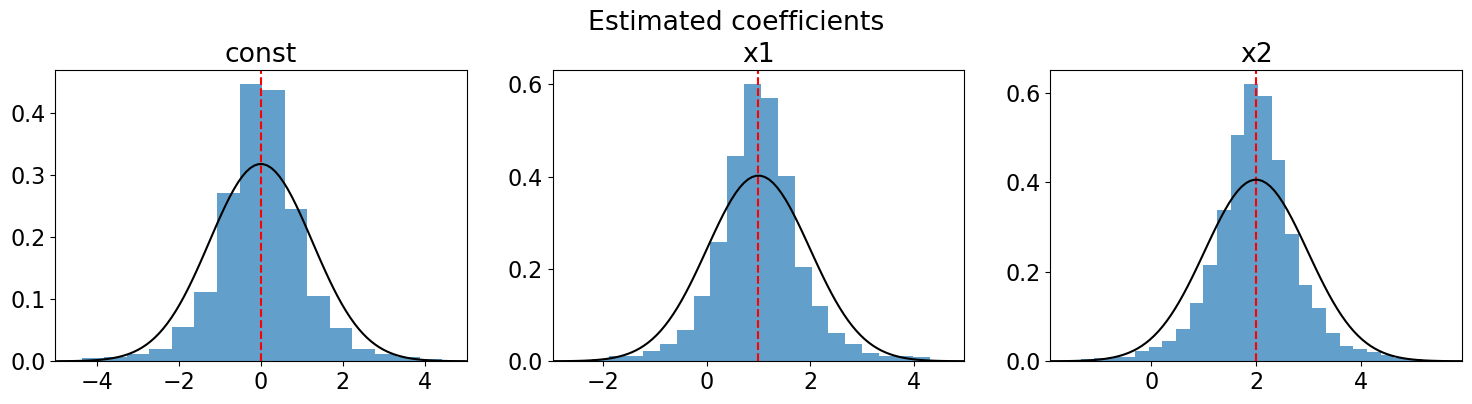

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
const,const,0,0.01012,1.255416,0.909843
x1,x1,1,1.015912,0.992193,0.708371
x2,x2,2,1.986727,0.983077,0.715185


In [9]:
n=5; beta=[1,2,3] # prøv at øge n, og betragt fordeling af β 
b, se = monte_carlo(lambda: simulate(n, beta=beta0, sigma_u=1), S=10000)
histogram(stat=b, truestat=beta0, title='Estimated coefficients', bins=100);
summary_table(b,se, beta0)

### Monte Carlo 2: OLS i store stikprøver - under MLR.1-MLR.4
- $\mathbf{\hat{\beta}}$ er asymptotisk unbiased, normalfordelt, med kendt varians
$$		\sqrt{n}(\hat{\beta} - \beta) \overset{a}{\sim} N\left(0, \sigma^2 A^{-1} \right),$$ 
hvor $A=p\lim \frac{1}{n}(X'X)$ og $\sigma^2 A^{-1}$ er variansen i den asymptotiske fordeling

Standard fejl
- $sd(\hat{\beta})$ findes som kvadratroden af diagonal elementerne i $\hat{\sigma}^2 (X'X)^{-1}$



### Asymptotisk fordeling af OLS estimatoren
- Bemærk at MLR.6 (normalitet) ikke er opfyldt, da $u$, $x_1$ ,og $\eta$ følger t-fordeling med 3 frihedsgrader
- Er MLR.6 er vigtig for at opnå asymptotisk normalitet?

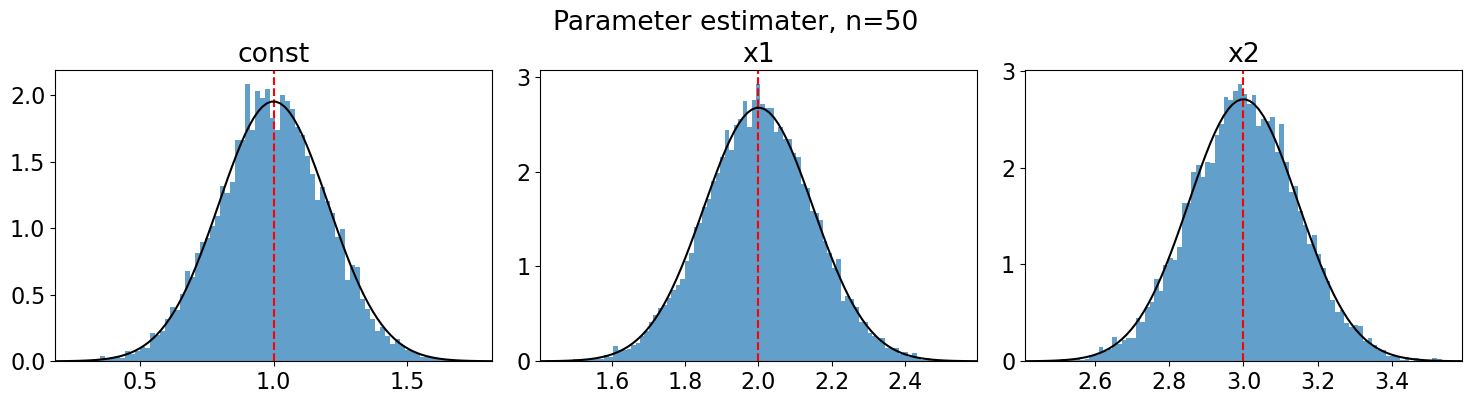

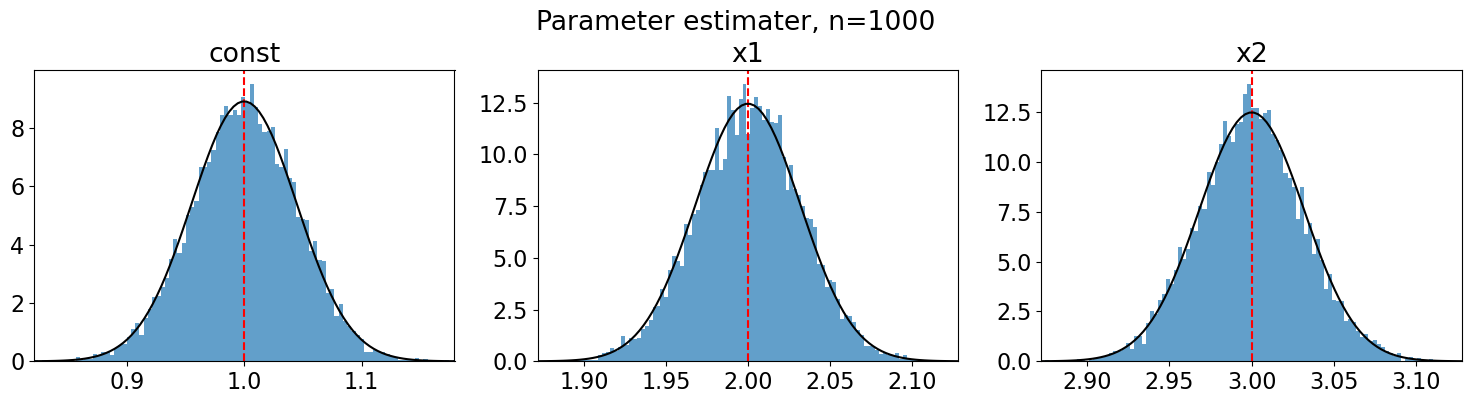

In [10]:
beta0=[1,2,3];
simulator_n= lambda n: simulate(n, beta=beta0, dist='t')
simulator_n= lambda n: simulate(n, beta=beta0, sigma_u=1, mu_x1=0, sigma_x1=1, mu_eta=1, sigma_eta=1,rho_x=0, rho_xu=0, dist='normal')
n=50; b, se = monte_carlo(lambda: simulator_n(n), S=10000)
histogram(stat=b, truestat=beta0, bins=100, title=f'Parameter estimater, n={n}');

n=1000; b, se = monte_carlo(lambda: simulator_n(n), S=10000)
histogram(stat=b, truestat=beta0, bins=100, title=f'Parameter estimater, n={n}');

### Monte Carlo for varierende stikprøve størrelse, $n$

In [ ]:
N1 = np.arange(5, 51, 1); N2 = np.arange(60, 101, 10); N3 = np.arange(200, 1001, 100); # start, stop, step
N = np.concatenate([N1, N2, N3])
mean_b = np.empty((len(N), len(beta0)))
mean_se = np.empty((len(N), len(beta0)))
for i, n in enumerate(N):
    b, se = monte_carlo(lambda: simulator_n(n), S=1000)
    mean_b[i] = b.mean()
    mean_se[i] = se.mean()

### OLS er asymptotisk unbiased
$$		\sqrt{n}(\hat{\beta} - \beta) \overset{a}{\sim} N\left(0, \sigma^2 A^{-1} \right),$$ 

- $E(\hat{\beta}) = \beta$ med faldende varians for vokesnde $n$

In [ ]:
col = ['r', 'g', 'b']
for k, beta in enumerate(beta0):
    plt.plot(N, mean_b[:, k], color=col[k])  # Line for estimated betas
    plt.fill_between(N, mean_b[:, k] - 1.96 * mean_se[:, k], mean_b[:, k] + 1.96 * mean_se[:, k], 
                          alpha=0.2, color=col[k])  # Confidence intervals
    plt.axhline(y=beta, color=col[k], linestyle='--', label=f'$\\beta_{k+1}$')  # Dashed line for true beta
plt.xlabel('Sample size')
plt.ylabel('$\\hat{\\beta}$')
plt.legend()
plt.show()

### Asymptotisk varians
$$		\sqrt{n}(\hat{\beta} - \beta) \overset{a}{\sim} N\left(0, \sigma^2 A^{-1} \right),$$ 

Afhænger $A=p\lim \frac{1}{n}(X'X)$ og $\sigma^2 A^{-1}$ af n?

In [ ]:
n=1000000 # sæt n stor for at beregne Plim (prøv at ændre n og se om A og Avar ændres)
sigma_u0=1;
#simulator_n= lambda n: simulate(n, beta=beta0, sigma_u=sigma_u0, dist='normal')
df = simulator_n(n)
X=df[['const', 'x1', 'x2']]
A=X.T @ X/n;  
Avar= sigma_u0**2*np.linalg.inv(A)
print(f'A: \n{A.round(4)}\n')
print(f'Avar: \n{Avar.round(4)}')

### Med hvilken rate konvergerer $\hat{\beta}$ mod den sande værdi $\beta$?
$$		\sqrt{n}(\hat{\beta} - \beta) \overset{a}{\sim} N\left(0, \sigma^2 A^{-1} \right)$$
- $\sigma^2 A^{-1}$ er konstant
- $\widehat{Var({\hat{\beta}}})=\hat{\sigma}^2 (X'X)^{-1}$ konvergerer mod 0 med hastighed $1/n$.
- Standardfejlen konvergerer med hastighed $1/\sqrt{n}$

###  $\sqrt{n}$ konsistens
- $\widehat{Var({\hat{\beta}}})=\hat{\sigma}^2 (X'X)^{-1}$ konvergerer mod 0 med hastighed $1/n$.
- Standardfejlen konvergerer mod 0 med hastighed $1/\sqrt{n}$

In [ ]:
for k, beta in enumerate(beta0):
    plt.plot(N, mean_se, color = col[k])
plt.xlabel('Sample size')
plt.ylabel('se($\\hat{\\beta}$)')
plt.show()

###  Konvergens mod asyptotisk varians
- $1/n\widehat{Var({\hat{\beta}}})$ konvergerer mod $\sigma^2 A^{-1}=\sigma^2 p\lim(X'X /n)^{-1}$
- Standardfejlen ganget med $\sqrt{n}$ konvergerer mod $\sqrt{\sigma^2 A^{-1}}$

In [ ]:
sqrt_Avar = np.sqrt(np.diag(Avar))
for k, beta in enumerate(beta0):
    plt.plot(N, np.sqrt(N).reshape(-1, 1)*mean_se)
    plt.axhline(y=sqrt_Avar[k],  color=col[k], linestyle='--', label=r'$\sqrt{\sigma^2A^{-1}}_{\beta_{k+1}}$')
plt.xlabel('Sample size')
plt.ylabel(r'$\sqrt{n}$se($\hat{\beta}$)')
plt.legend()
plt.show()

## Hypotese test
- Vi ønsker f.eks. at teste hypotesen $H_0$ mod det dobbelt sidede alternativ $H_1: \beta_j \neq a_j$

$$H_0: \beta_j = a_j \quad H_1: \beta_j \neq a_j $$

- Test størrelse
$$t=\frac{\hat{\beta}_j-a_j}{\sqrt{Var(\hat{\beta}_j)}} \sim t(n-k)$$
p-værdi
$$
		\text{p-værdi} = 2 \cdot P(T \geq |t|) = 2 \cdot \left(1 - \text{CDF}(|t|; n-k-1)\right)
$$

In [ ]:
from scipy import stats
def t_test(b, a, se, df): # test H0 b=a vs H1: b ne a
    t_stat =(b - a) / se 
    t_np = t_stat.to_numpy(dtype='float64')  # Ensure it's converted to float64
    p_val = 2 * (1 - stats.t.cdf(np.abs(t_np), df=df))
    return t_stat, p_val

### t-test størrelsen er t-fordelt (og asymptotisk normalfordelt)

In [ ]:
a=beta0.copy();          # Nulhypotese: H0: β=β0 (β = true value)
# a=np.array([1,2,3.1]);   # Nulhypotese: H0: β=a (try changing a to value different from true beta)
for n in [8, 1000]: 
    b, se = monte_carlo(lambda: simulate(n, beta=beta0, dist='t'), S=10000)
    t_stat, p_val = t_test(b,a,se, n-3)
    histogram(t_stat,  ((b-beta0)/se).mean(), title=f'T-ratios, n={n}', bins=100);

### Signifikansniveau og Type 1-fejl

- **Signifikansniveauet** $ \alpha$ angiver sandsynligheden for at forkaste nulhypotesen $H_0 $, når den er sand (**Type 1-fejl**). 
    - Ved $ \alpha = 0.05 $ accepterer vi en 5% risiko for at lave denne fejl.

- **Simulation:** beregn vi hvor ofte vi fejlagtigt forkaster $H_0$, når $H_0$ er sand. 
    - Denne andel repræsenterer risikoen for en Type 1-fejl.

In [ ]:
alpha=0.05 # significance level
n=100 # try to change n
beta0=np.array([1,2,3]) # try to change beta
a=beta0.copy();     # beta under H0 (true)
simulator_t = lambda: simulate(n, beta=beta0, sigma_u=1, dist='normal')
b, se = monte_carlo(simulator_t, S=10000)
t_stat, p_val = t_test(b,a,se, n-3)
reject = (p_val < alpha)
print(f'Significance level: {alpha}')
print(f'Probability of rejecting true H0: {np.mean(reject, axis=0)}')

### Power/styrke: Sandsynlighed for at undgå type 2 fejl

- **Type 2-fejl** opstår, når vi ikke forkaster $ H_0 $, selvom det er falsk.
- **Testets styrke (power)**: Sandsynligheden for at forkaste $ H_0 $, når det er falsk.
    - Styrken afhænger af, hvor meget nulhypotesen afviger fra sandheden.
    - Styrken øges med flere observationer (mindre standardfejl).

I nedenstående kode beregnes styrken ved at simulere data under $ H_0 $, når $ H_0 $ er falsk, og derefter undersøges, hvor ofte vi korrekt forkaster $ H_0 $.

In [ ]:
n=10 # try to change n
alpha=0.05 # significance level
beta0=[1,2,3]       # true beta
a=np.array([0,0,0]) # try to change beta under H0 (false)
simulator_t = lambda: simulate(n, beta=beta0, sigma_u=1, dist='normal')
b, se = monte_carlo(simulator_t, S=10000)
t_stat, p_val = t_test(b,a,se, n-3)
reject = (p_val < alpha)
power =  np.mean(reject, axis=0)
print(f'Significance level: {alpha}')
print(f'Power: Probability of rejecting false H0: {power}')